In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 4.8 MB/s 


In [3]:
## IMPORTS 
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import random 
import torch
import torchvision 
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as T

#import torchvision
#from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 


#import splitfolders
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import glob
import time
import PIL
from PIL import Image
import os
import cv2
import timm

In [4]:
## IMPORTING THE MIDAS NETWORK

model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt" to /root/.cache/torch/hub/checkpoints/dpt_large-midas-2f21e586.pt


  0%|          | 0.00/1.28G [00:00<?, ?B/s]

In [5]:
## COMPUTATIONAL RESSOURCES 

!nvidia-smi

Mon Jul 25 13:29:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Activate cuda
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [7]:
## GHOST CITY MODEL

# Original images 
#full_data_path='/content/drive/MyDrive/ghost_city_model/images'
#output_images='/content/drive/MyDrive/ghost_city_model/images_split'

#Associated depth maps
#full_depth_maps_path = '/content/drive/MyDrive/ghost_city_model/depth_maps'
#output_depth_maps='/content/drive/MyDrive/ghost_city_model/depth_maps_split'


In [8]:
## MEDIUM STRUCTURE MODEL

# Original images 
full_data_path='/content/drive/MyDrive/medium_structure_model/images_resized_256/class0'


#Associated depth maps
full_depth_maps_path = '/content/drive/MyDrive/medium_structure_model/depth_maps_resized_256/class0'


In [55]:
#LOADING DATA

def load_data(data_path, verbose=False):
    DATA_LOADED=False 
    print_every_n_loads=10
    images=[]
    ind=0
    t0=time.time()
    if not DATA_LOADED:
      print('Loading data...')
      list_dir = os.listdir(data_path)
      list_dir=sorted(list_dir, key=lambda x: x.lower())
      for filename in list_dir:
          if ind<5:
            print(str(filename))
          img = mpimg.imread(os.path.join(data_path, filename))
          if img is not None:
              images.append(np.asarray(img))
              ind+=1
          if verbose:
              if ind%print_every_n_loads==0:
                  print('nb of data loaded:', ind)
      print(f'Loaded data in: {time.time()-t0 } s')
    return images

images=load_data(full_data_path)
depth_maps=load_data(full_depth_maps_path)

Loading data...
resized_256_20220514T001442.000Z.jpg
resized_256_20220514T001444.000Z.jpg
resized_256_20220514T001446.000Z.jpg
resized_256_20220514T001448.000Z.jpg
resized_256_20220514T001450.000Z.jpg
Loaded data in: 0.4120213985443115 s
Loading data...
resized_256_depth_20220514T001442.000Z.png
resized_256_depth_20220514T001444.000Z.png
resized_256_depth_20220514T001446.000Z.png
resized_256_depth_20220514T001448.000Z.png
resized_256_depth_20220514T001450.000Z.png
Loaded data in: 0.5483059883117676 s


l'ordre pas respecté dans les images!!

In [56]:
DATA_LOADED=True
#NUM_TRAIN=len(train_images)
#NUM_VAL=len(val_images)
#NUM_TEST=len(test_images)
#H, W, C=train_images[0].shape
#print(NUM_TRAIN, NUM_VAL, NUM_TEST)
SCALE_FACTOR=1000 #Need to increaze the really small values in the depth_maps data,
# otherwise, during transformation, all elements are set to zero.

In [57]:
## Using different metrics to evaluate performances of the network

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

#A loss robust to outliers + large data values 

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(torch.abs(pred + 1)), torch.log(torch.abs(actual + 10))))

In [58]:
class Original_and_Depth_Map(torch.utils.data.Dataset):

    def __init__(self, datasetA, datasetB, transform=None):
        self.datasetA = np.array(datasetA).astype(np.uint8)
        self.datasetB = (np.array(datasetB)*1000).astype(np.uint8)
        self.transform= transform
        #self.meanA, self.stdA=get_mean_std(datasetA)
        #self.meanB, self.stdB=get_mean_std(datasetB)
        #self.transformA = T.Compose([T.ToTensor()
       #, T.Normalize(self.meanA, self.stdA)
        #])
        #self.transformB=T.ToTensor()
        #self.transformB = T.Compose([  T.ToTensor(), T.Normalize(self.meanB, self.stdB),
       #])
    

        
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]

        if self.transform:
          return self.transform(xA), self.transform(xB)
        
        return xA, xB

    def __len__(self):
        return len(self.datasetA)

In [59]:
# LOADING THE NECESSARY MIDAS TRANSFORM

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform_midas = midas_transforms.dpt_transform
else:
    transform_midas = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [75]:
batch_size = 2

# CREATING THE TRAIN VAL AND TEST DATASETS

full_dataset =Original_and_Depth_Map(images, depth_maps)
train_and_eval_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_and_eval_size
train_and_eval, test_dataset = torch.utils.data.random_split(full_dataset, [train_and_eval_size, test_size])

train_size= int(0.9 * len(train_and_eval))
val_size = len(train_and_eval) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_and_eval, [train_size, val_size])

#DATALOADERS
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

99


<Figure size 432x288 with 0 Axes>

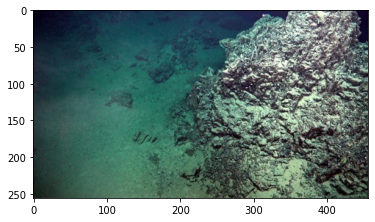

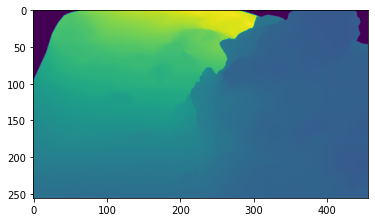

<Figure size 432x288 with 0 Axes>

In [76]:
ind=np.random.randint(105)
print(ind)
plt.imshow(full_dataset[ind][0])
plt.figure()
plt.imshow(full_dataset[ind][1])
plt.figure()
#ORDRE OK!!

In [69]:
#Training function

def train_epoch(network, device, dataloader, optimizer, loss_function, print_every = 1):
    """ Trains the simple model for one epoch. losses_resolution indicates how often training_loss should be printed and stored. """
    network.train()
    train_losses = []
    # Iterate the dataloader (We do not need the label value which is 0 here, the depth maps are the labels)
    iter = 0
    for image, depth_map in dataloader: 
        im = cv2.cvtColor(image[0].numpy(), cv2.COLOR_BGR2RGB)
        im = transform_midas(im).to(device)
        
        
        d = depth_map[0].to(device)
        

        d_hat = network(im)

        #Coming from the midas output size to the initial input size 
        d_hat= torch.nn.functional.interpolate(
        d_hat.unsqueeze(1),
        size=d.shape,
        mode="bicubic",
        align_corners=False,
        )
        #print('d size:', d.shape)
        #print('d_hat size:', d_hat.shape)

        #Computing the loss, storing it
        loss = loss_function(d_hat, d)

        # Backward pass
        optimizer.zero_grad()  # Sets the gradients attached to the parameters objects to zero.
        loss.backward()  # Uses the gradient object attached to the loss to recursively compute the gradients of the parameters of the network (and store their value in the gradient objects attached to said parameters)
        optimizer.step()  # Actually chages the values of the parameters using their gradients, computed on the previous line of code.
        
        # Print and store batch loss
        batch_loss = loss.item()/d.shape[0]
        train_losses.append(batch_loss)
        
        #Display
        #if iter%print_every == 0:
            #print(f'\t partial train loss (single batch): {batch_loss:.2f}')
    return train_losses

In [70]:
## Testing function

def validation_epoch(network, device, loss_function, dataloader):
    "Set evaluation mode for encoder and decoder"
    network.to(device)
    network.eval()  # evaluation mode, equivalent to "network.train(False)""
    val_loss = 0
    with torch.no_grad(): # No need to track the gradients
        for image, depth_map in dataloader:
            
            im = cv2.cvtColor(image[0].numpy(), cv2.COLOR_BGR2RGB)
            im = transform_midas(im).to(device)
            
            
            d = depth_map[0].to(device)
            

            d_hat = network(im)

            #Coming from the midas output size to the initial input size 
            d_hat= torch.nn.functional.interpolate(
            d_hat.unsqueeze(1),
            size=d.shape,
            mode="bicubic",
            align_corners=False,
            )
            #print('d size:', d.shape)
            #print('d_hat size:', d_hat.shape)

            #Computing the loss, storing it
            loss = loss_function(d_hat, d)
            val_loss += loss.item()/d.shape[0]

    return val_loss/len(dataloader)


In [80]:
#Plotting the learning and validation loss curves


def plot_learning_curves(train_losses, val_losses):
    """ Plots the learning curve. Losses resolution (how many times the loss is displayed) is one value per batch for the training losses, and one value per epoch for the validation. """
    iterations_train = np.arange(0, batch_size*train_losses.size, batch_size)
    iterations_validation = np.arange(0, train_size*val_losses.size, train_size)

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.plot(iterations_train, train_losses, color="blue", label="training loss")
    ax.plot(iterations_validation, val_losses/1e6, color="orange", label = "validation loss")
    ax.set(xlabel="iterations", ylabel="loss", title="Training and validation losses over iterations")
    ax.grid()
    ax.legend()

    fig.show()

In [81]:
## Plotting function

def plot__outputs(network, number_outputs=5, random_plots=True, indices=None):
  """
    When random_plots = True, different images are taken between each epoch.
    When random_plots = False, indices indicates what images to plot
  """
  fig = plt.figure(figsize=(5*number_outputs,8.5))
  
  #Selection of random images to plot within the dataset or a select set of indices
  if random_plots:
      plotted_samples = np.random.choice(test_size, number_outputs)
  else:
      plotted_samples = indices
  
  for i in range(number_outputs):
      ax = plt.subplot(3, number_outputs, i+1)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # plt.subplot(nb_rows, nb_cols, num)  where num is indexed from 1
      image = test_dataset[plotted_samples[i]][0]
      network.eval()
      
      with torch.no_grad():
        im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        im = transform_midas(im).to(device)
        
        output_img  = network(im)
        
        output_img=torch.nn.functional.interpolate(
        output_img.unsqueeze(1),
        size=(im.shape[2], im.shape[3]),
        mode="bicubic",
        align_corners=False,
        ).squeeze()

      #right_size_im=np.transpose(im.cpu().squeeze().numpy(), (1, 2, 0))
      #plt.imshow(right_size_im*255)
      plt.imshow(test_dataset[plotted_samples[i]][0])
      if i == number_outputs//2:
          ax.set_title('Original images')
    
      

      ax = plt.subplot(3, number_outputs, i + 1 + number_outputs)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.imshow(output_img.cpu().numpy(), cmap='gray')
      if i == number_outputs//2:
          ax.set_title('Reconstructed depth maps')
      
      ax=plt.subplot(3, number_outputs, i + 1 + 2*number_outputs)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      #plt.imshow(test_dataset[plotted_samples[i]][1], cmap='gray')
      plt.imshow(test_dataset[plotted_samples[i]][1], cmap='gray')
      if i == number_outputs//2:
          ax.set_title('Original depth maps')



In [77]:
## Training and Validation processes


## Choice of different parameters
lr=1e-3
weight_decay=1e-3 #Weight regularization to avoid overfitting
number_of_plotted_images = 5
plot_images_every_n_epochs = 2
random_plots = True
indices_to_plot = np.arange(number_of_plotted_images)
num_epochs= 10
optim=torch.optim.Adam(midas.parameters(), lr=lr, weight_decay=weight_decay)

## Choice of the loss
mse=nn.MSELoss()
rmse=RMSELoss()
rmsle=RMSLELoss()


train_losses = np.array([])
val_losses = np.array([validation_epoch(midas, device, rmsle, val_loader)])


## Training process

for epoch in range(num_epochs):
   train_losses_epoch = train_epoch(midas, device, train_loader,optim, rmsle)
   val_loss_epoch = validation_epoch(midas, device, rmsle, val_loader)
   train_losses = np.concatenate((train_losses, train_losses_epoch))
   val_losses = np.append(val_losses, val_loss_epoch)
   print(f'\n EPOCH {epoch + 1}/{num_epochs} \t train loss {train_losses_epoch[-1]:.3f} \t val loss {val_loss_epoch:.3f}')



#Plotting 5 images at the end of the reconstruction
# To see the evolution of the reconstruction, integrate in the for loop.

#plot_ae_outputs(midas, number_outputs=number_of_plotted_images, random_plots=random_plots, indices=indices_to_plot)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([256, 456])) that is different to the input size (torch.Size([1, 1, 256, 456])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



 EPOCH 1/10 	 train loss 0.016 	 val loss 0.017

 EPOCH 2/10 	 train loss 0.017 	 val loss 0.017

 EPOCH 3/10 	 train loss 0.017 	 val loss 0.017

 EPOCH 4/10 	 train loss 0.017 	 val loss 0.017

 EPOCH 5/10 	 train loss 0.017 	 val loss 0.017

 EPOCH 6/10 	 train loss 0.017 	 val loss 0.017

 EPOCH 7/10 	 train loss 0.017 	 val loss 0.017

 EPOCH 8/10 	 train loss 0.016 	 val loss 0.017

 EPOCH 9/10 	 train loss 0.016 	 val loss 0.017

 EPOCH 10/10 	 train loss 0.017 	 val loss 0.017


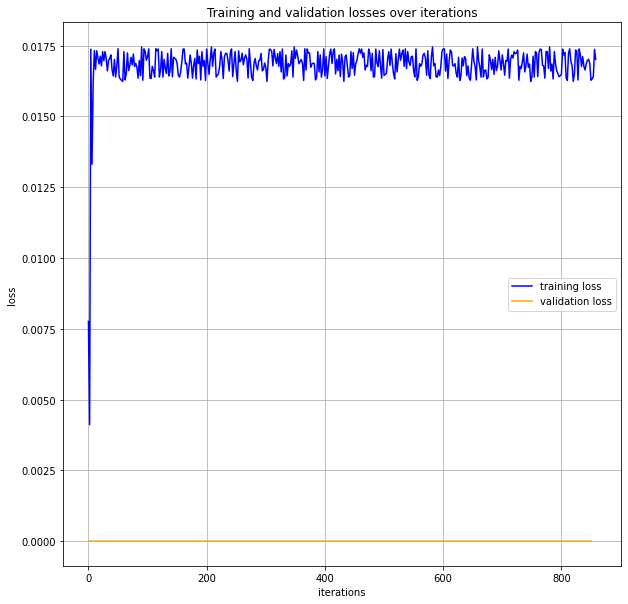

In [82]:
# Losses with medium_structure_model
plot_learning_curves(train_losses, val_losses)


This result is unconsistent. This is normal as the dataset is extremely small compared to the complexity of the MiDas network. 

Moreover, I did a really little number of epochs.



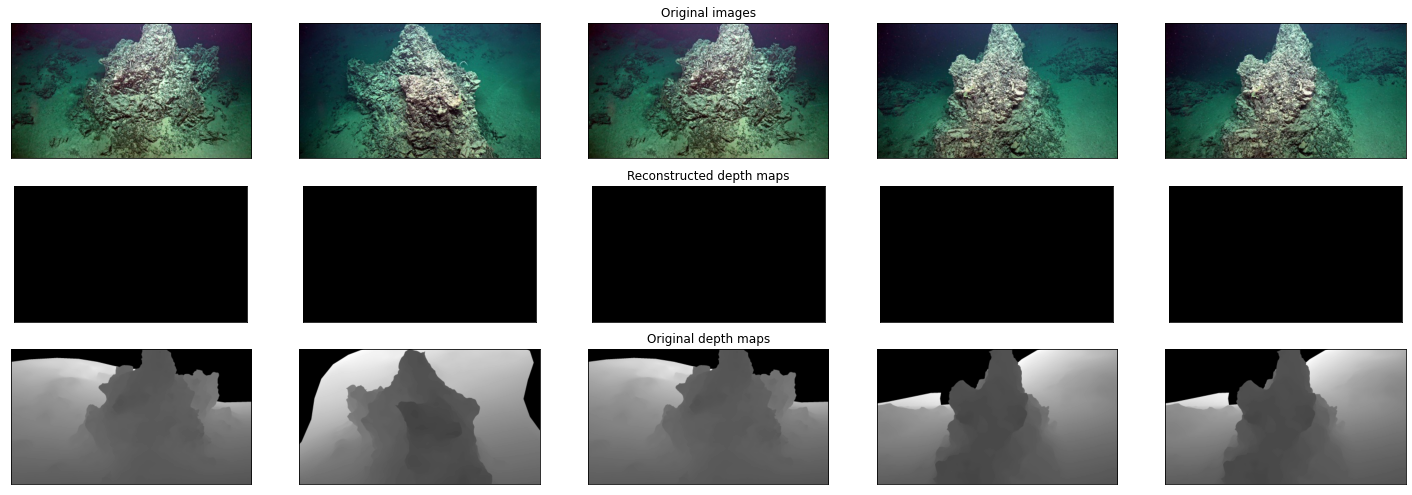

In [83]:
# How do the reconstructed depth maps look like......

plot__outputs(midas, number_outputs=5, random_plots=True, indices=None)